In [ ]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from google.colab import drive
from scipy.signal import butter, filtfilt

# 1.1 Gaussian kernel
Implement function gaussian2D(sigma, kernel_size) that returns a 2D gaussian blur kernel, with input argument sigma specifying a tuple of x,y scales (standard deviations), and kernel_size specifying a tuple of x,y dimensions of the kernel. The kernel should be large enough to include 3 standard deviations per dimension.

In [ ]:
def gaussian2D(sigma, kernel_size):
  x_size, y_size = kernel_size
  center_x = x_size // 2
  center_y = y_size // 2

  # Generate 2D Gaussian kernel by applying the low pass filter
  x, y = np.mgrid[-center_x:center_x+1, -center_y:center_y+1]
  sigx = sigma[0]
  sigy = sigma[1]
  kernel = (1 / (2 * np.pi * sigx * sigy)) * np.exp(-((x**2 / (2 * (sigx**2)) + y**2 / (2 * (sigy**2)))))
  kernel = kernel / np.sum(kernel)
  return kernel

# 1.2 Create Hybrid Images
Choose two images (A and B) of your choice that you will blend with one another and convert them to grayscale (you can use opencv.cvtColor). These images can be of faces, or any other objects. Try to make the objects in the two images occupy roughly the same region in the image (if they don’t you can use the imwarp function you wrote in Homework 1 to manually align them!).Construct a hybrid image C from A (to be seen close-up) and B (to be seen far away) as follows: C = blur(B) + (A-blur(A)), where blur is a function that lowpass filters the image (use the Gaussian kernel you coded in 1.1 for this). Try different values of sigma for the Gaussian kernel. How does the amount of blurring affect your perception of the results? In your report, please show your input images labeled clearly as A and B, and attach the result C for a value of sigma which you feel demonstrates the illusion the best, at both the original size and a downsampled size. Please implement the downsampling operation yourself! As a sanity check, you should be able to see the identity change when looking at the original and downsampled versions.

<Figure size 640x480 with 0 Axes>

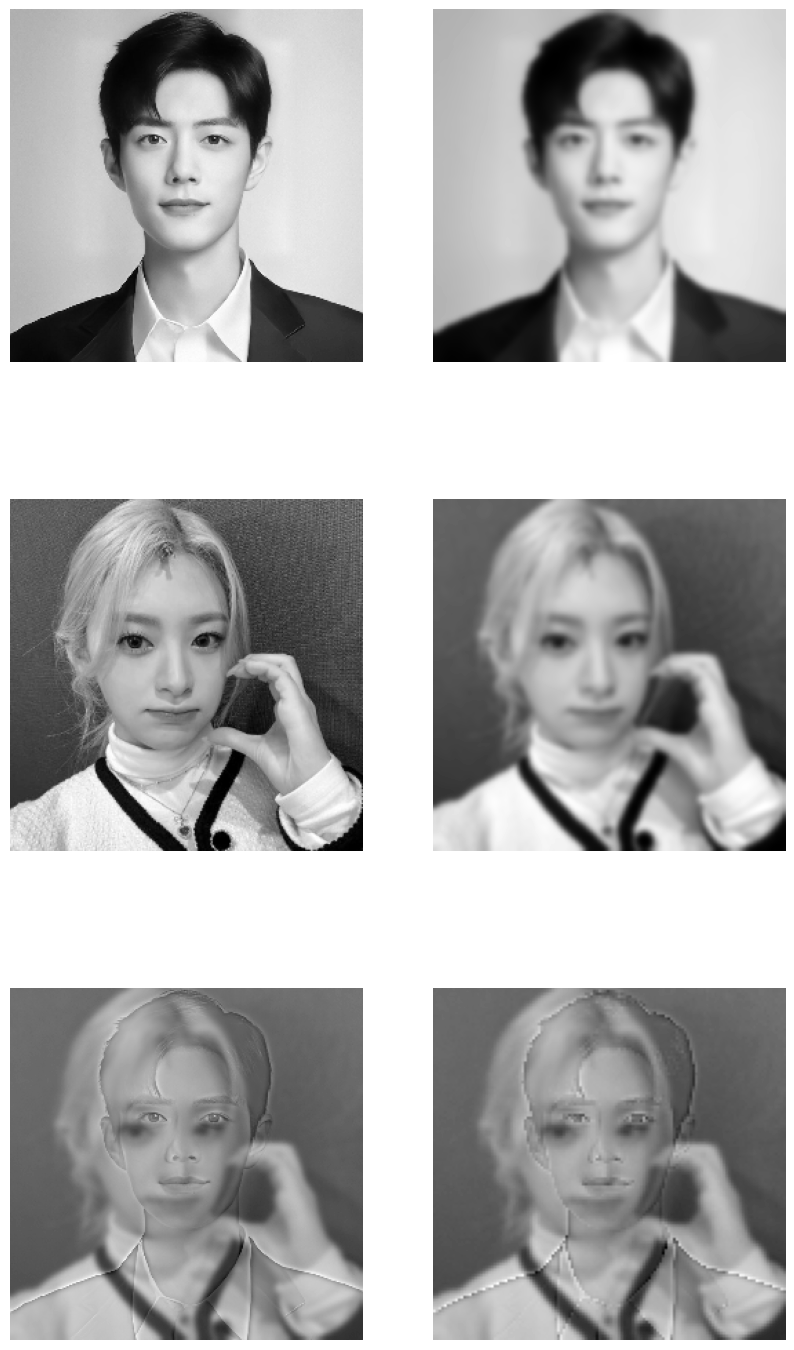

In [ ]:
A = Image.open('handsome.jpg')
A = np.array(A, dtype=np.float32)
A = cv2.resize(A, (256, 256))
A_gray = cv2.cvtColor(A, cv2.COLOR_RGB2GRAY)
B = Image.open('beauty.jpg')
B = np.array(B, dtype=np.float32)
B = cv2.resize(B, (256, 256))
B_gray = cv2.cvtColor(B, cv2.COLOR_RGB2GRAY)

sigma = (2,2)
kernel_size = (24, 24)

# Blur the image
kernel = gaussian2D(sigma, kernel_size)
A_blur = cv2.filter2D(A_gray, -1, kernel)
B_blur = cv2.filter2D(B_gray, -1, kernel)

# Construct C
C = B_blur + (A_gray - A_blur)

# Downsample
downsample_factor = 2
downsampled_C = C[::downsample_factor, ::downsample_factor]

# C_downsampled = cv2.pyrDown(C)

plt.figure()
fig, res = plt.subplots(3, 2, figsize=(10, 18))
images = [A_gray, A_blur,
      B_gray, B_blur,
      C, downsampled_C]
index = 0
for i in range(3):
  for j in range(2):
    res[i][j].imshow(images[index], cmap="gray")
    res[i][j].axis('off')
    index += 1

# 1.3 Fourier Spectra

For the sigma value you chose in 1.2, show images of the Fourier spectra magnitudes of images A, B, blur(B), A-blur(A), and C. You can get the magnitude of the Fourier spectrum coefficients of an image ‘x’ by running:
X = numpy.abs(numpy.fft.fftshift(numpy.fft.fft2(x)))
By default, numpy.fft2 will place the zero frequency (DC component) of the spectrum at the top left of the image, and so numpy.fft.fftshift is used here to place the zero frequency at the center of the image. When displaying the Fourier spectrum with matplotlib.pyplot.imshow, the image will likely look black. This is because the DC component typically has a much higher magnitude than all other frequencies, such that after rescaling all values to lie in [0,1], most of the image is close to 0. To overcome this, display the logarithm of the values instead.

<Figure size 640x480 with 0 Axes>

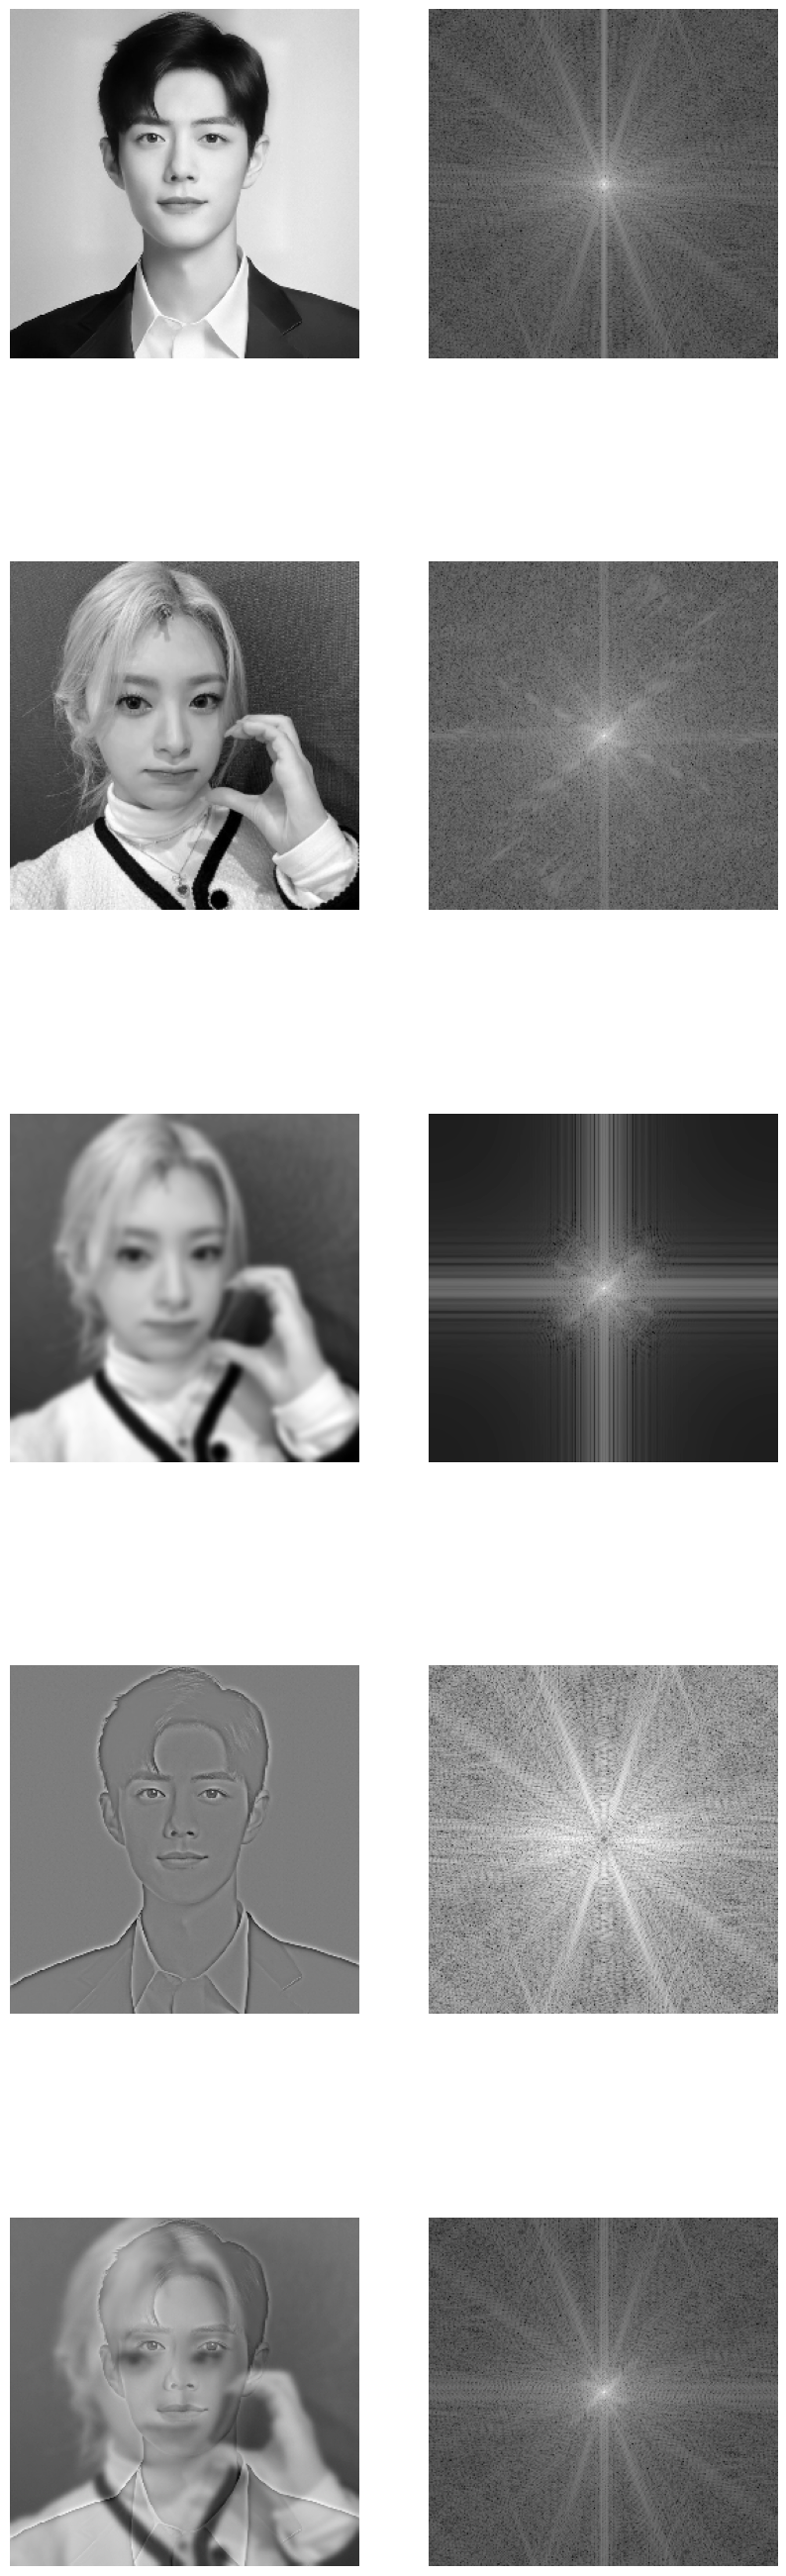

In [ ]:
A_minus_blur = A_gray - A_blur
A_gray_spectrum = np.log(np.abs(np.fft.fftshift(np.fft.fft2(A_gray))))
B_gray_spectrum = np.log(np.abs(np.fft.fftshift(np.fft.fft2(B_gray))))
B_blur_spectrum = np.log(np.abs(np.fft.fftshift(np.fft.fft2(B_blur))))
A_minus_blur_spectrum = np.log(np.abs(np.fft.fftshift(np.fft.fft2(A_minus_blur))))
C_spectrum = np.log(np.abs(np.fft.fftshift(np.fft.fft2(C))))

plt.figure()
fig, res = plt.subplots(5, 2, figsize=(10, 35))
images = [A_gray, A_gray_spectrum,
      B_gray, B_gray_spectrum,
      B_blur, B_blur_spectrum,
      A_minus_blur, A_minus_blur_spectrum,
      C, C_spectrum]
index = 0
for i in range(5):
  for j in range(2):
    res[i][j].imshow(images[index], cmap="gray")
    res[i][j].axis('off')
    index += 1

# 2.1 Gaussian Pyramid
Write a function gausspyr(I, n_levels, sigma)that returns a Gaussian pyramid for image I with number of levels n_levels and Gaussian kernel scale sigma. The function should return a list of images, with element i corresponding to level i of the pyramid. Note that level 0 should correspond to the original image I, and level n_levels - 1 should correspond to the coarsest (lowest frequency) image.

In [ ]:
def gausspyr(I, n_levels, sigma):
  res = []
  res.append(I)
  for i in range(1, n_levels):
    kernel_size= (int(6*sigma[0]), int(6*sigma[1]))
    kernel = gaussian2D(sigma, kernel_size)
    I_blur = cv2.filter2D(I, -1, kernel)

    # Downsample
    downsample_factor = 2
    downsampled = I_blur[::downsample_factor, ::downsample_factor]

    res.append(downsampled)
    I = downsampled
  return res

# 2.2 Laplacian Pyramid
Write a function lappyr(I, n_levels, sigma)that returns a Laplacian pyramid for image I with number of levels n_levels and Gaussian kernel sigma. The function should return a list of images, with element i corresponding to level i of the pyramid. Note that level 0 corresponds to the details of the original image I, and level n_levels - 1 corresponds to the low-frequency residual image. Please implement the downsampling operations yourself!

In [ ]:
upsampling_matrix = np.array([[0.25, 0.5, 0.25],
          [0.5, 1, 0.5],
          [0.25, 0.5, 0.25]])

def lappyr(I, n_levels, sigma):
  res = []
  for i in range(n_levels - 1):
    kernel_size= (int(6*sigma[0]), int(6*sigma[1]))
    kernel = gaussian2D(sigma, kernel_size)
    I_blur = cv2.filter2D(I, -1, kernel)

    # Downsample
    downsample_factor = 2
    downsampled = I_blur[::downsample_factor, ::downsample_factor]

    # Upsample
    upsampled = cv2.pyrUp(downsampled)
    # temp = cv2.filter2D(upsampled, -1, upsampling_matrix)
    # item = I - temp
    item = I - upsampled
    res.append(item)

    # Should insert the downsampled image as the last element
    if i == n_levels-2:
       res.append(downsampled)

    I = downsampled
  return res

# 2.3 Image Blending
Choose two images A and B depicting different objects and resize them to the same shape. You may want to use your imwarp function from Homework 1 to align the scales/orientations of the objects appropriately (as was done in the example in Fig. 2) so that the resulting blend will be most convincing. Create a binary mask image mask which will have 1s in its left half, and 0s in its right half (called a ‘step’ function). Perform blending with the following operations:
1.
Build Laplacian pyramids for A and B.
2.
Build a Gaussian pyramid for mask.
3.
Build a blended Laplacian pyramid for output image C using pyramids of A, B, and mask, where each level 𝑙𝑘𝐶 is defined by the equation 𝑙𝑘𝐶=𝑙𝑘𝐴∗𝑚𝑘+𝑙𝑘𝐵∗(1−𝑚𝑘).
4.
Invert the combined Laplacian pyramid back into an output image C.
Show the following in your report: (1) Images from all levels of the Laplacian pyramids for A and B, (2) images from all levels of the Gaussian pyramid for mask, and (3) your final blended image C.

In [ ]:
def display_pyramid(pyramid, title):
  fig, axs = plt.subplots(1, len(pyramid), figsize=(20, 5))
  for i, level in enumerate(pyramid):
      level_normalized = (level.astype(np.float32) - level.min()) / (level.max() - level.min())
      axs[i].imshow(level_normalized)
      axs[i].set_title("Level {}".format(i))
      axs[i].axis('off')
  plt.suptitle(title)
  plt.show()

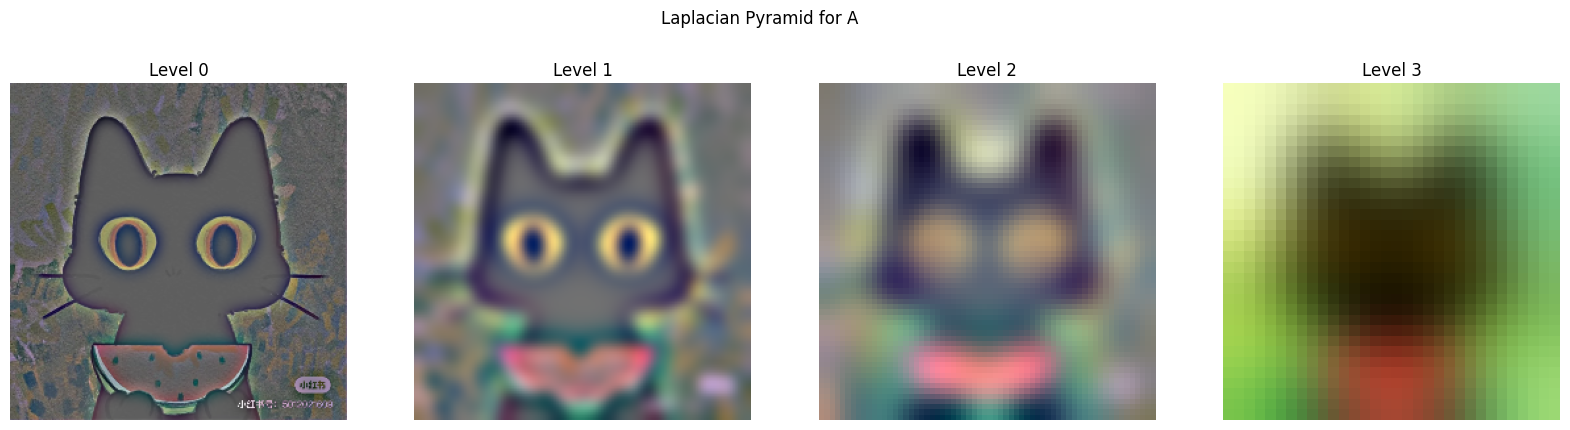

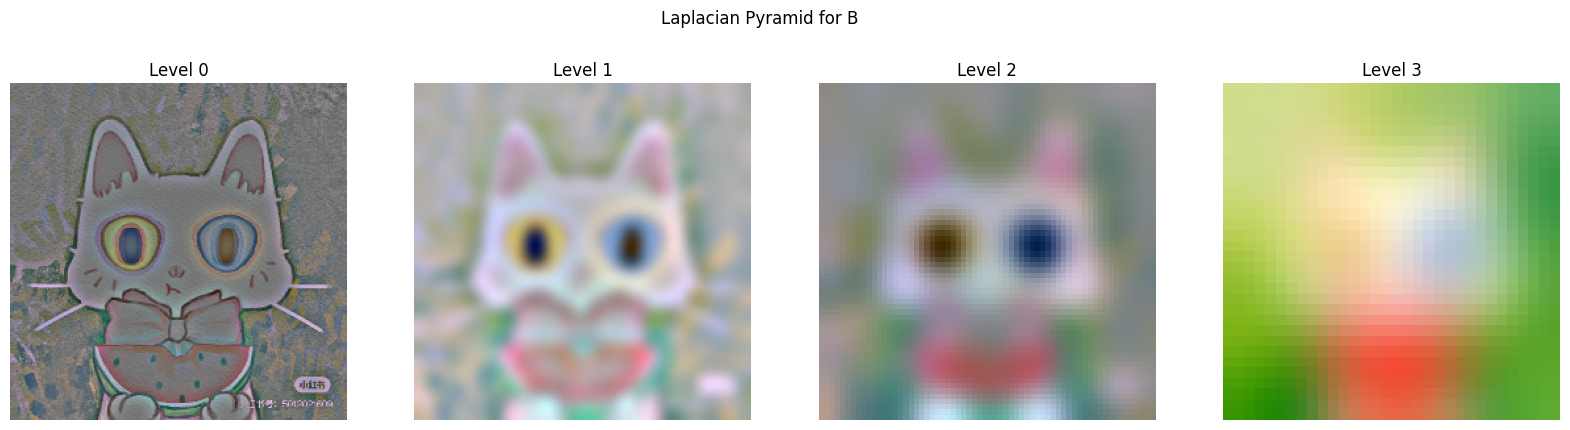

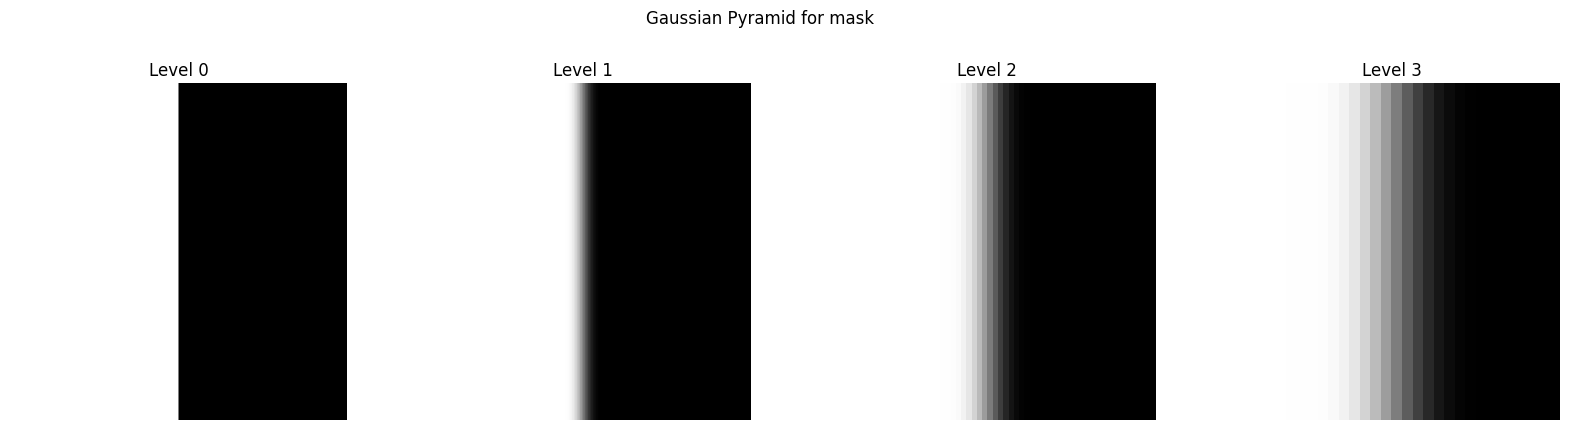

In [ ]:
A = Image.open('black.jpg')
A = np.array(A, dtype=np.float32)
B = Image.open('white.jpg')
B = np.array(B, dtype=np.float32)
A = cv2.resize(A, (256, 256))
B = cv2.resize(B, (256, 256))
# print("A shape: ", A.shape)
# print("B shape: ", B.shape)

# Create the mask
mask = np.zeros(A.shape, dtype=np.float32)
mask[:, :A.shape[1] // 2] = 1
# mask[:, :A.shape[1] // 2, :] = 1
mask = cv2.resize(mask, (256, 256))

n_levels = 4
sigma = (4,4)
laplacian_A = lappyr(A, n_levels, sigma)
laplacian_B = lappyr(B, n_levels, sigma)
gaussian_mask = gausspyr(mask, n_levels, sigma)

# Display the Laplacian pyramid for A, B and mask
display_pyramid(laplacian_A, "Laplacian Pyramid for A")
display_pyramid(laplacian_B, "Laplacian Pyramid for B")
display_pyramid(gaussian_mask, "Gaussian Pyramid for mask")

# Blending the image
blended = []
for i in range(n_levels):
  combined = laplacian_A[i] * gaussian_mask[i] + laplacian_B[i] * (1.0 - gaussian_mask[i])
  blended.append(combined)

# Start inverting
ans = blended[-1]
for i in range(n_levels - 2, -1, -1):
  # Upsample
  upsampled_ans = cv2.pyrUp(ans)
  # temp_ans = cv2.filter2D(upsampled_ans, -1, upsampling_matrix)
  # ans = temp_ans + blended[i]
  ans = upsampled_ans + blended[i]
ans = np.clip(ans, 0, 255).astype(np.uint8)

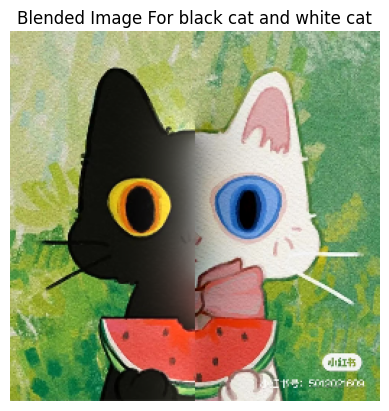

In [ ]:

plt.imshow(ans);
plt.title("Blended Image For black cat and white cat")
plt.axis(False);

# 3.1 Read video into notebook and define regions of interest (2 points)
Upload the video into your Colab environment. Note that it may take several minutes for the upload to complete due to the size of the file. You can then read the video frames into a numpy array using the read_video_into_numpy function provided here.
Using the first video frame, manually define rectangles (row and column boundaries) that capture 1) one of the cheeks and 2) the forehead.

In [ ]:
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Colab Notebooks/COMP447/"

Mounted at /content/drive


In [ ]:
# Provided functions
def read_video_into_numpy(filename):
  cap = cv2.VideoCapture(filename)
  frames = []
  while cap.isOpened():
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
      print("Can't receive frame (stream end?). Exiting ...")
      break

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame)

  cap.release()
  video = np.stack(frames, axis=0)#converts to numpy array(T,H,W,C)
  video = np.transpose(video, (1,2,3,0))#(T,H,W,C)->(H,W,C,T)
  return frames

def bandpass_filter(signal, low_cutoff, high_cutoff, fs, order):
  nyquist = 0.5 * fs
  low = low_cutoff / nyquist
  high = high_cutoff / nyquist
  b, a = butter(order, [low, high], btype='band')
  filtered_signal = filtfilt(b, a, signal)

  return filtered_signal

In [ ]:
alice = read_video_into_numpy(path + "alice.avi")

Can't receive frame (stream end?). Exiting ...


Text(0.5, 1.0, 'First frame')

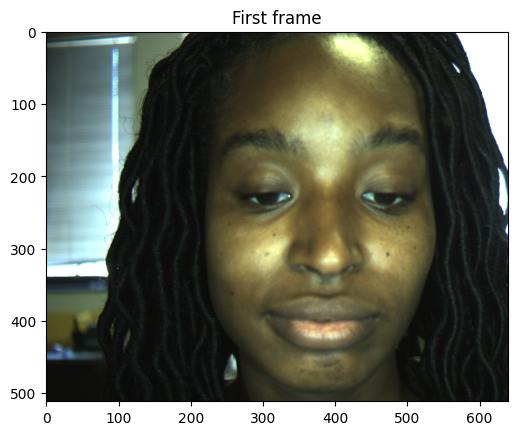

In [ ]:
first_frame = alice[0]
plt.imshow(first_frame)
plt.title("First frame")

In [ ]:
# manually find cheek and forehead
cheek = first_frame[260:380, 450:520, :]
forehead = first_frame[30:140, 300:480, :]

Text(0.5, 1.0, 'Cheek')

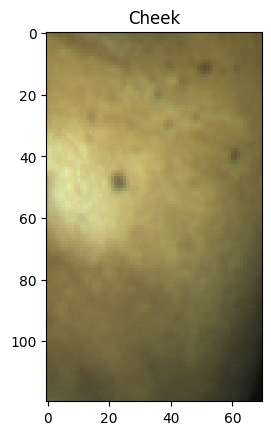

In [ ]:
plt.imshow(cheek)
plt.title("Cheek")

Text(0.5, 1.0, 'Forehead')

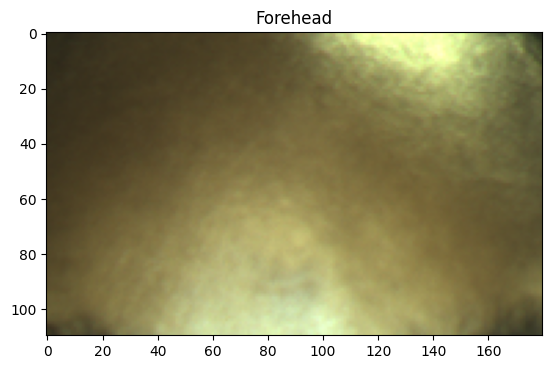

In [ ]:
plt.imshow(forehead)
plt.title("Forehead")

# 3.2 Compute signals (2 points)
Now compute the average Green value of pixels for all frames for each facial region (cheek, forehead). This gives a 1D signal in time called the Photoplethysmogram (PPG) for each region.

In [ ]:
cheek_agv = []
forehead_agv = []
for frame in alice:
  cheek_area = frame[260:380, 450:520, :].copy()
  forehead_area = frame[30:140, 300:480, :].copy()
  cheek_agv.append(np.mean(cheek_area[:, :, 1]))
  forehead_agv.append(np.mean(forehead_area[:, :, 1]))

# 3.3 Bandpass filter (3 points)
It is often useful to filter a signal to a particular band of frequencies of interest (‘pass band’) if we know that other frequencies don’t matter. In this application, we know that a normal resting heart rate for an adult ranges between 60-100 beats per minute (1-1.7 Hz). Apply the bandpass_filter function to your signals provided here. You can set low_cutoff = 0.8, high_cutoff = 3, fs = 30, order = 1. Plot the filtered signals.

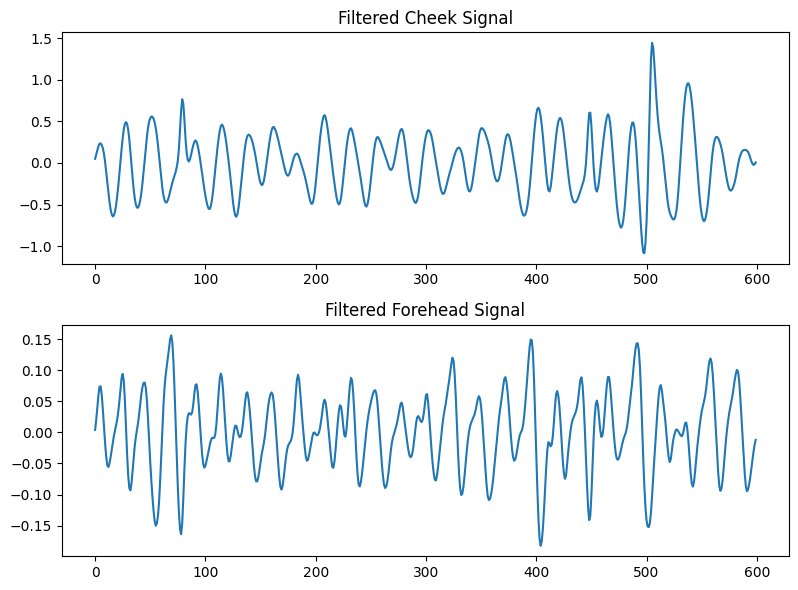

In [ ]:
cheek_filter = bandpass_filter(cheek_agv, 0.8, 3, 30, 1)
forehead_filter = bandpass_filter(forehead_agv, 0.8, 3, 30, 1)

# Plot
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
plt.plot(cheek_filter, label='Filtered Cheek')
plt.title('Filtered Cheek Signal')
plt.subplot(2, 1, 2)
plt.plot(forehead_filter, label='Filtered Forehead')
plt.title('Filtered Forehead Signal')
plt.tight_layout()
plt.show()

# 3.4 Plot Fourier spectra (4 points)
Plot the Fourier magnitudes of these two signals using the DFT, where the x-axis is frequency (in Hertz) and y-axis is amplitude. DFT coefficients are ordered in terms of integer indices, so you will have to convert the indices into Hertz. For each index n = [- N/2, N/2], the corresponding frequency is Fs * n / N, where N is the length of your signal and Fs is the sampling rate of the signal (30 Hz in this case). You can also use numpy.fft.fftfreq to do this conversion for you.

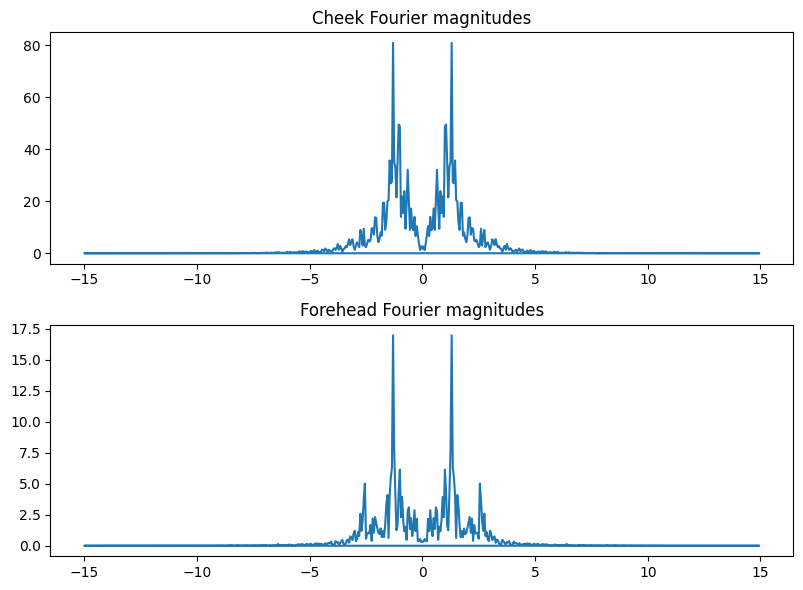

In [ ]:
cheek_fourier = np.abs(np.fft.fft(cheek_filter))
forehead_fourier = np.abs(np.fft.fft(forehead_filter))

Fs = 30.0
cheek_freq = np.fft.fftfreq(len(cheek_filter), d=1/Fs)
forehead_freq = np.fft.fftfreq(len(forehead_filter), d=1/Fs)

# Plot
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
plt.plot(cheek_freq, cheek_fourier, label='Cheek Fourier magnitudes')
plt.title('Cheek Fourier magnitudes')
plt.subplot(2, 1, 2)
plt.plot(forehead_freq, forehead_fourier, label='Forehead Fourier magnitudes')
plt.title('Forehead Fourier magnitudes')
plt.tight_layout()
plt.show()

# 3.5 Estimate Alice’s average pulse rate (4 points)
A normal resting heart rate for adults ranges between 60-100 beats per minute. What rate does the highest peak in Alice’s Fourier spectrum correspond to? Which facial region provides the cleanest spectrum (the one which has the clearest single peak and low energy elsewhere)? Is Alice likely a human or not?

In [ ]:
cheek_peak = np.argmax(cheek_fourier)
cheek_max_freq = cheek_freq[cheek_peak]
cheek_rate = cheek_max_freq * 60
print("Rate calculated from cheek: " + str(cheek_rate))

forehead_peak = np.argmax(forehead_fourier)
forehead_max_freq = forehead_freq[forehead_peak]
forehead_rate = forehead_max_freq * 60
print("Rate calculated from forehead: " + str(forehead_rate))

Rate calculated from cheek: 78.0
Rate calculated from forehead: 78.0
